## Importing Required Packages

In [1]:
from fastai.vision.all import *
from pathlib import Path
import numpy as np
import os
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *
from fastai.callback.fp16 import *
from semtorch import get_segmentation_learner



/home/newrun2/Projects/Marwen/venv/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [2]:
path = Path("./data/train")

In [3]:
path.ls()


(#5) [Path('data/train/codes.txt'),Path('data/train/.DS_Store'),Path('data/train/masks'),Path('data/train/models'),Path('data/train/images')]

In [4]:
fnames = get_image_files(path/"images")
fnames[0]

Path('data/train/images/01308.png')

In [5]:
(path/"masks").ls()[0]


Path('data/train/masks/01308.png')

In [6]:
### Function to make correspondace between images and masks
def label_func(fn): return path/"masks"/f"{fn.stem}{fn.suffix}"


In [7]:
label_func(fnames[0])

Path('data/train/masks/01308.png')

In [8]:
def MaskBlockCustom(codes=None):
    "A `TransformBlock` for segmentation masks, potentially with `codes`"
    return TransformBlock(type_tfms=PILMask.create, item_tfms=AddMaskCodes(codes=codes), 
                          batch_tfms=IntToFloatTensor(div_mask=255))

### Create Datablock

In [9]:
# !pip install albumentations

from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    Flip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

In [10]:
# Class for data augmentation
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): 
        self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])
    
transformPipeline=Compose([
                        Flip(p=0.5),
                        Transpose(p=0.5),
                        Rotate(p=0.40,limit=10)
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transformPipeline)

In [11]:
def get_dls(bs, size):
    "Return dataloader"

    nuclie_seg = DataBlock(blocks=(ImageBlock, MaskBlockCustom()),
                       get_items = get_image_files,
                       get_y = label_func,
                       splitter=RandomSplitter(),
                       item_tfms=[Resize((size,size)),transformPipeline],
                       batch_tfms=Normalize.from_stats(*imagenet_stats),
                    )
    return nuclie_seg.dataloaders(path/"images", path=path, bs=bs)


In [12]:
dls = get_dls(8,156)


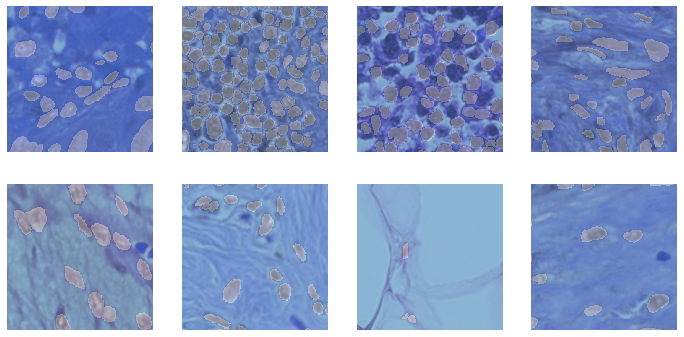

In [13]:
dls.show_batch(max_n=10)


In [14]:
class Dice(Metric):
    "Dice coefficient metric for binary target in segmentation"
    def __init__(self, axis=1): self.axis = axis
    def reset(self): self.inter,self.union = 0,0
    def accumulate(self, learn):
        pred,targ = flatten_check(learn.pred.argmax(dim=self.axis), learn.y)
        pred, targ = TensorBase(pred), TensorBase(targ)
        self.inter += (pred*targ).float().sum().item()
        self.union += (pred+targ).float().sum().item()

    @property
    def value(self): return 2. * self.inter/self.union if self.union > 0 else None

##  Train Model

## ResNet101

In [15]:
monitor_training="valid_loss"
comp_training=np.less

monitor_evaluating="dice"
comp_evaluating=np.greater

patience=2

In [16]:
# !pip install efficientnet-pytorch

In [17]:
dls = get_dls(6,156)

fname="ResNet101_best_before_resizing"

callbacksFitBeforeResizing = [
    ShowGraphCallback(),
#     EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating,comp=comp_evaluating,every_epoch=False,fname=fname)  
]

In [18]:
learn = unet_learner(dls, resnet101,n_out=2,metrics=Dice(),wd=1e-3,self_attention=True).to_fp16()


In [19]:
learn.summary()

DynamicUnet (Input shape: ['6 x 3 x 156 x 156'])
Layer (type)         Output Shape         Param #    Trainable 
                     6 x 64 x 78 x 78    
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     6 x 256 x 39 x 39   
Conv2d                                    16384      False     
BatchNorm2d                               512        True      
ReLU                                                           
______________________

epoch,train_loss,valid_loss,dice,time
0,0.194494,0.175638,0.782726,02:16


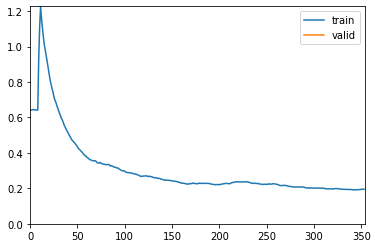

Better model found at epoch 0 with dice value: 0.7827263864145597.


epoch,train_loss,valid_loss,dice,time
0,0.155714,0.263950,0.789908,02:25
1,0.152870,0.147569,0.822825,02:21
2,0.146898,0.144498,0.823522,02:21
3,0.138371,0.138215,0.832607,02:21
4,0.139416,0.144792,0.834815,02:21
5,0.124820,0.147347,0.835206,02:21
6,0.129333,0.130998,0.841893,02:21
7,0.122207,0.127408,0.846303,02:21
8,0.123968,0.126357,0.845993,02:21
9,0.117315,0.126309,0.847057,02:21


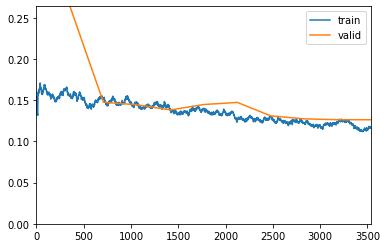

Better model found at epoch 0 with dice value: 0.7899076022663343.
Better model found at epoch 1 with dice value: 0.8228254633076348.
Better model found at epoch 2 with dice value: 0.8235219536780619.
Better model found at epoch 3 with dice value: 0.8326066048779289.
Better model found at epoch 4 with dice value: 0.834815251706668.
Better model found at epoch 5 with dice value: 0.8352059419843793.
Better model found at epoch 6 with dice value: 0.8418927150441128.
Better model found at epoch 7 with dice value: 0.8463032994560565.
Better model found at epoch 9 with dice value: 0.8470569050137007.


In [20]:
learn.fine_tune(10,cbs=callbacksFitBeforeResizing)

In [18]:
#Loading checkpoints
learn.load(fname)
learn.validate()

/home/newrun2/Projects/Marwen/venv/lib/python3.7/site-packages/fastai/learner.py:55: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#2) [0.1151510700583458,0.8589060670380015]

#### Progressive Resizing

In [19]:
learn.dls = get_dls(2,256)

fname="ResNet101_best_after_resizing"

callbacksFitAfterResizing = [
    ShowGraphCallback(),
#     EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating,comp=comp_evaluating,every_epoch=False,fname=fname)  
]

epoch,train_loss,valid_loss,dice,time
0,0.155141,0.142520,0.827174,05:59


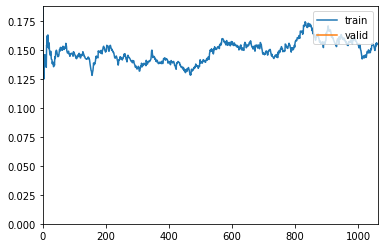

Better model found at epoch 0 with dice value: 0.827174037948575.


epoch,train_loss,valid_loss,dice,time
0,0.132791,0.142436,0.806424,06:30
1,0.144478,0.138718,0.825704,06:32
2,0.135599,0.138023,0.828104,06:36
3,0.142864,0.135595,0.833143,06:46
4,0.126534,0.135430,0.836823,06:36
5,0.126382,0.131448,0.835297,06:31
6,0.120607,0.133760,0.830121,06:30
7,0.116298,0.127041,0.841040,06:31
8,0.121675,0.127999,0.839478,06:32
9,0.110136,0.126921,0.839212,06:31


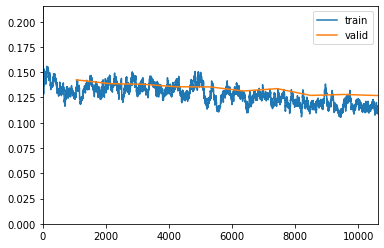

Better model found at epoch 0 with dice value: 0.8064241780920715.
Better model found at epoch 1 with dice value: 0.8257036341338991.
Better model found at epoch 2 with dice value: 0.8281044198045274.
Better model found at epoch 3 with dice value: 0.8331432177665758.
Better model found at epoch 4 with dice value: 0.8368234903808717.
Better model found at epoch 7 with dice value: 0.8410404065649134.


In [20]:
learn.fine_tune(10,cbs=callbacksFitAfterResizing)

In [21]:
### Unfreezing

Recorder

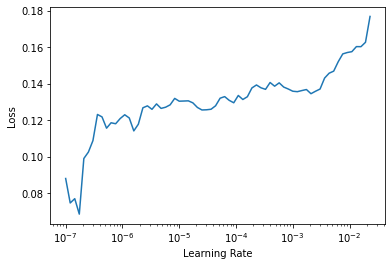

In [22]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder 

In [22]:
#Loading checkpoints
learn.load(fname)
learn.validate()

(#2) [0.1249055564403534,0.8543430324923237]

epoch,train_loss,valid_loss,dice,time
0,0.116325,0.123728,0.854216,05:57
1,0.108459,0.123904,0.854071,05:54
2,0.120404,0.123986,0.852313,05:56


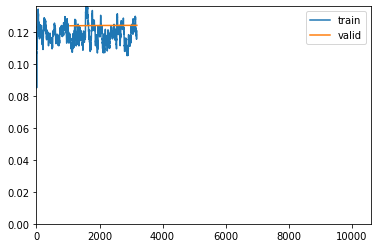

Better model found at epoch 0 with valid_loss value: 0.1237282007932663.
No improvement since epoch 0: early stopping


In [23]:
fname="ResNet101_best_after_resizing_and unfreezing"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(7e-7,2e-6),cbs=callbacksFitAfterUnfreeze)

In [20]:
fname="ResNet101_best_after_resizing_and unfreezing"

learn.load(fname)
learn.validate()

/home/newrun2/Projects/Marwen/venv/lib/python3.7/site-packages/fastai/learner.py:55: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#2) [0.12028507143259048,0.8556665384587757]

### SavingModel

In [21]:
learn.export(fname="./models/restnet101_final.pkl")

### ResNet50

epoch,train_loss,valid_loss,dice,time
0,0.201420,0.166756,0.778025,01:42


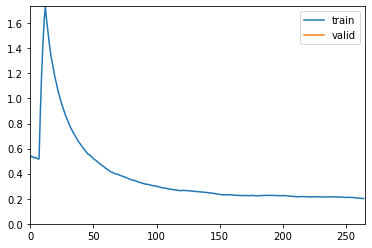

Better model found at epoch 0 with valid_loss value: 0.1667555868625641.


epoch,train_loss,valid_loss,dice,time
0,0.155794,0.140602,0.821228,01:45
1,0.148822,0.138110,0.831527,01:44
2,0.140706,0.133492,0.825761,01:44
3,0.137855,0.128560,0.836301,01:45
4,0.131780,0.127582,0.845104,01:45
5,0.125724,0.124000,0.846333,01:45


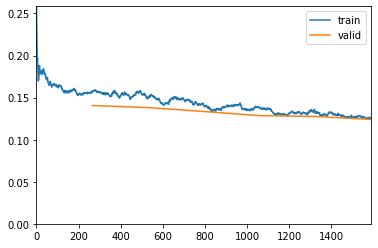

Better model found at epoch 0 with valid_loss value: 0.1406015008687973.
Better model found at epoch 1 with valid_loss value: 0.13811038434505463.
Better model found at epoch 2 with valid_loss value: 0.1334916204214096.
Better model found at epoch 3 with valid_loss value: 0.1285601258277893.
Better model found at epoch 4 with valid_loss value: 0.12758198380470276.
Better model found at epoch 5 with valid_loss value: 0.12400010228157043.


In [34]:
learn.fine_tune(6,cbs=callbacksFitBeforeResizing)

#### Result 

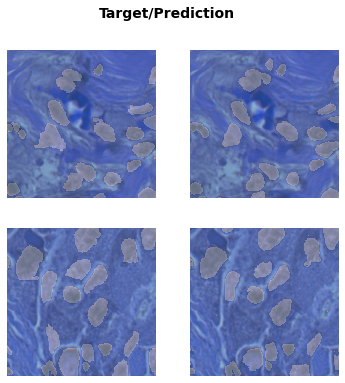

In [35]:
learn.show_results()

#### Progressive Resizing

In [37]:
fname="ResNet50_best_after_resizing"

callbacksFitAfterResizing = [
    ShowGraphCallback(),
#     EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]

In [39]:
learn.dls = get_dls(4, 256)


epoch,train_loss,valid_loss,dice,time
0,0.157504,0.146581,0.811151,04:03


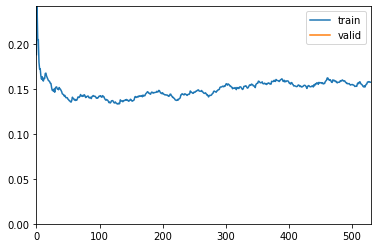

Better model found at epoch 0 with valid_loss value: 0.14658135175704956.


epoch,train_loss,valid_loss,dice,time
0,0.135883,0.127068,0.840077,04:06
1,0.136360,0.127471,0.837577,04:06
2,0.128327,0.130543,0.834408,04:05
3,0.131640,0.126002,0.837127,04:05
4,0.130078,0.124934,0.841194,04:06
5,0.122168,0.119484,0.848566,04:05
6,0.125189,0.118527,0.850405,04:06
7,0.118653,0.117173,0.851335,04:06
8,0.118496,0.117194,0.852197,04:05
9,0.115638,0.116512,0.853248,04:05


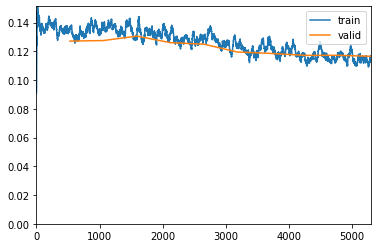

Better model found at epoch 0 with valid_loss value: 0.12706810235977173.
Better model found at epoch 3 with valid_loss value: 0.12600240111351013.
Better model found at epoch 4 with valid_loss value: 0.12493359297513962.
Better model found at epoch 5 with valid_loss value: 0.11948437243700027.
Better model found at epoch 6 with valid_loss value: 0.1185268983244896.
Better model found at epoch 7 with valid_loss value: 0.11717250198125839.
Better model found at epoch 9 with valid_loss value: 0.11651182174682617.


In [40]:
learn.fine_tune(10,cbs=callbacksFitAfterResizing)

### DenseNet

In [41]:
fname="Densenet121_best"

callbacksFitBeforeResizing = [
    ShowGraphCallback(),
#     EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]

In [51]:
dls = get_dls(4,156)


In [52]:
learn = unet_learner(dls,densenet ,n_out=2,metrics=Dice(),cbs=callbacksFitBeforeResizing).to_fp16()

epoch,train_loss,valid_loss,dice,time
0,0.361872,0.270292,0.581432,04:30


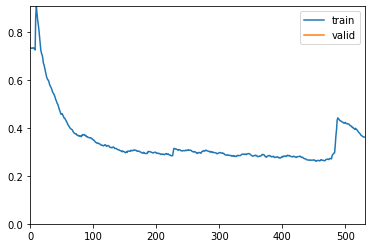

Better model found at epoch 0 with valid_loss value: 0.2702917456626892.


epoch,train_loss,valid_loss,dice,time
0,0.231609,0.207259,0.719478,04:40
1,0.230725,0.205454,0.745399,04:40
2,0.212722,0.194953,0.740847,04:40
3,0.204118,0.186951,0.739003,04:40
4,0.197582,0.176740,0.770150,04:39
5,0.197341,0.179930,0.753621,04:40


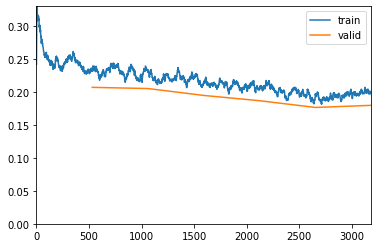

Better model found at epoch 0 with valid_loss value: 0.20725856721401215.
Better model found at epoch 1 with valid_loss value: 0.20545363426208496.
Better model found at epoch 2 with valid_loss value: 0.19495268166065216.
Better model found at epoch 3 with valid_loss value: 0.18695068359375.
Better model found at epoch 4 with valid_loss value: 0.17673993110656738.


In [53]:
learn.fine_tune(6)

### SemTorch

In [22]:
dls = get_dls(4,256)

In [23]:
def segmentron_splitter(model):
    return [params(model.backbone), params(model.head)]

In [24]:
fname="deeplabv3-segmentron-resnet50-manual-data-augmentation-before-resizing-WD-2-best"
callbacksFitBeforeResizing = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]

In [25]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="deeplabv3+", backbone_name="resnet50", 
                                 metrics= Dice(),wd=1e-3,pretrained=True,normalize=True).to_fp16()

In [26]:
learn.freeze() # Freezing the backbone

Recorder

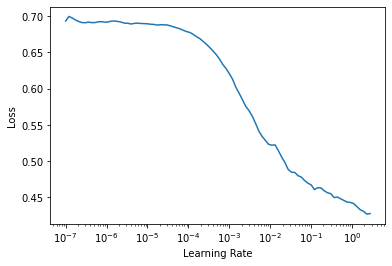

In [27]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,dice,time
0,0.208373,0.224849,0.689284,00:59
1,0.194472,0.204655,0.720399,00:58
2,0.184637,0.209208,0.706880,00:59
3,0.169511,0.174148,0.779760,00:58
4,0.164856,0.176742,0.769259,00:59
5,0.149687,0.158897,0.807281,00:59
6,0.148987,0.154315,0.806523,00:58
7,0.141211,0.147826,0.818681,01:00
8,0.133680,0.144629,0.822372,00:59
9,0.134893,0.143769,0.823264,00:59


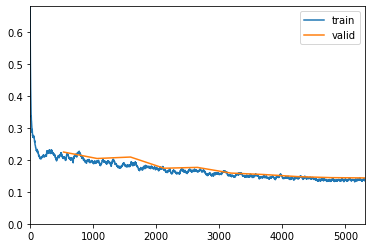

Better model found at epoch 0 with valid_loss value: 0.2248491495847702.
Better model found at epoch 1 with valid_loss value: 0.2046547681093216.
Better model found at epoch 3 with valid_loss value: 0.1741476207971573.
Better model found at epoch 5 with valid_loss value: 0.15889735519886017.
Better model found at epoch 6 with valid_loss value: 0.15431508421897888.
Better model found at epoch 7 with valid_loss value: 0.14782598614692688.
Better model found at epoch 8 with valid_loss value: 0.14462918043136597.
Better model found at epoch 9 with valid_loss value: 0.14376872777938843.


In [28]:
learn.fit_one_cycle(10, slice(3e-3,3e-2),cbs=callbacksFitBeforeResizing)

In [29]:
learn.load(fname)
learn.validate()

/home/newrun2/Projects/Marwen/venv/lib/python3.7/site-packages/fastai/learner.py:55: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#2) [0.14376872777938843,0.823264128189589]

Recorder

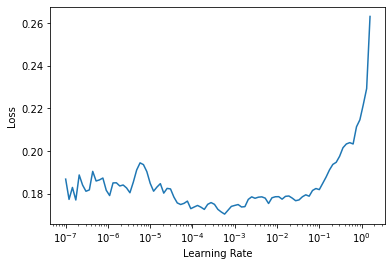

In [66]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

Recorder

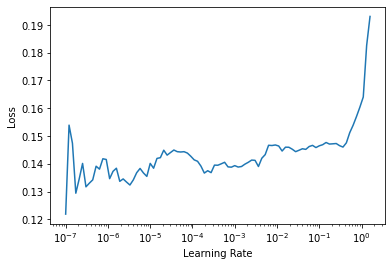

In [30]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

In [32]:
fname="deeplabv3-segmentron-resnet50-manual-data-augmentation-after-resizing-WD-3-best"
callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]

epoch,train_loss,valid_loss,dice,time
0,0.136377,0.144252,0.821557,00:58
1,0.140088,0.144916,0.821440,00:59
2,0.139169,0.143170,0.826147,00:59
3,0.140863,0.143625,0.823609,00:59
4,0.135142,0.143328,0.824898,00:59


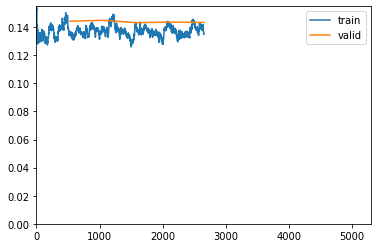

Better model found at epoch 0 with valid_loss value: 0.14425238966941833.
Better model found at epoch 2 with valid_loss value: 0.1431700885295868.
No improvement since epoch 2: early stopping


In [33]:
learn.fit_one_cycle(10, slice(3e-6,3e-5),cbs=callbacksFitAfterUnfreeze)

### UNet2

In [16]:
from semtorch.utils.metrics import DiceUSquaredNet


In [17]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)
        
        # Change 255 for 1
        mask[mask==255]=1
        
        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

Setting-up type transforms pipelines
Found 2656 items
2 datasets of sizes 2125,531
Setting up Pipeline: PILBase.create
Setting up Pipeline: label_func -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      data/train/images/01228.png
    applying PILBase.create gives
      PILImage mode=RGB size=256x256
  Pipeline: label_func -> PILBase.create
    starting from
      data/train/images/01228.png
    applying label_func gives
      data/train/masks/01228.png
    applying PILBase.create gives
      PILMask mode=L size=256x256

Final sample: (PILImage mode=RGB size=256x256, PILMask mode=L size=256x256)


Found 2656 items
2 datasets of sizes 2125,531
Setting up Pipeline: PILBase.create
Setting up Pipeline: label_func -> PILBase.create
Setting up after_item: Pipeline: AddMaskCodes -> TargetMaskConvertTransform -> Resize -- {'size': (256, 256), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pip

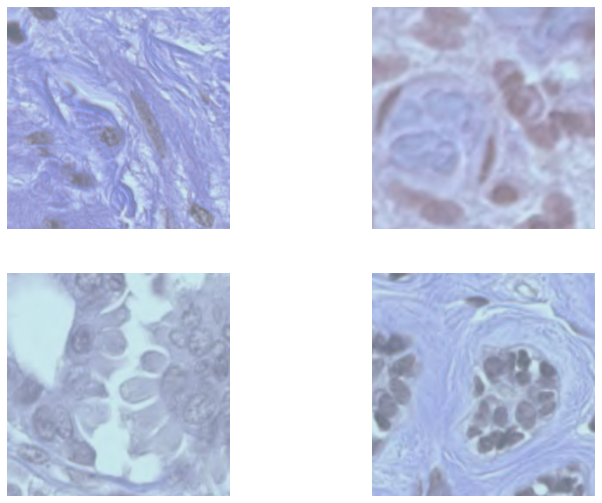

In [27]:
size = 256
bs = 4
manual = DataBlock(blocks=(ImageBlock, MaskBlock()),
                   get_items = get_image_files,
                       get_y = label_func,
                       splitter=RandomSplitter(),
                   item_tfms=[Resize((size,size)), TargetMaskConvertTransform()]                  )
manual.summary(path/"images")
dls = manual.dataloaders(path/"images",bs=bs)
dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

In [28]:
# dls = get_dls(8,156)


In [29]:
fname="u2net-data-augmentation-best"

callbacksBeforeResizing = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_evaluating,comp=comp_evaluating, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating,comp=comp_evaluating,every_epoch=False,fname=fname)  
]

In [30]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="u2^net", backbone_name="small", 
                                 metrics=[DiceUSquaredNet()],wd=1e-2,loss_func=CrossEntropyLossFlat()).to_native_fp16()
#learn.freeze() # Freezing the backbone

In [31]:
learn.summary()

U2NETP (Input shape: ['4 x 3 x 256 x 256'])
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 64 x 256 x 256  
Conv2d                                    1792       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     4 x 16 x 256 x 256  
Conv2d                                    9232       True      
BatchNorm2d                               32         True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    2320       True      
BatchNorm2d                               32         True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                     

In [32]:
learn.lr_find() # find learning rate


TypeError: no implementation found for 'torch.nn.functional.binary_cross_entropy_with_logits' on types that implement __torch_function__: [<class 'fastai.torch_core.TensorImage'>, <class 'fastai.torch_core.TensorMask'>]

In [31]:
learn.fit_one_cycle(15, slice(1e-4,1e-3),cbs=callbacksBeforeResizing)

FileNotFoundError: [Errno 2] No such file or directory: 'data/train/models/u2net-data-augmentation-best.pth'